### Author: Jason Quach
### UH ID: 2135612

### Imports

In [1]:
import json
import pandas as pd
from pathlib import Path
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [2]:
data = []
datasets = ["dblp-ref-0.json", "dblp-ref-1.json", "dblp-ref-2.json", "dblp-ref-3.json"]

for dataset in datasets:
    with open(Path("datasets") / dataset, "r") as f:
        for line in f:
            data.append(json.loads(line))

In [ ]:
df = pd.DataFrame(data)
print(df.head())
print(df.shape)

                                            abstract  \
0  The purpose of this study is to develop a lear...   
1  This paper describes the design and implementa...   
2  This article applied GARCH model instead AR or...   
3                                                NaN   
4                                                NaN   

                                             authors  n_citation  \
0  [Makoto Satoh, Ryo Muramatsu, Mizue Kayama, Ka...           0   
1                        [Gareth Beale, Graeme Earl]          50   
2  [Altaf Hossain, Faisal Zaman, Mohammed Nasser,...          50   
3  [Jea-Bum Park, Byungmok Kim, Jian Shen, Sun-Yo...           0   
4                [Giovanna Guerrini, Isabella Merlo]           2   

                                          references  \
0  [51c7e02e-f5ed-431a-8cf5-f761f266d4be, 69b625b...   
1  [10482dd3-4642-4193-842f-85f3b70fcf65, 3133714...   
2  [2d84c0f2-e656-4ce7-b018-90eda1c132fe, a083a1b...   
3  [8c78e4b0-632b-4293-b491-85

### Cleaning
- Removes 
    - Missing titles and venues 
    - Empty whitespace titles and venues 
    - Venues containing "arXiv"

- Reasons 
    - Dataset becomes more clean and consistant 
    - All training samples ahve usable text and labels 

In [4]:
df = df.dropna(subset=["title", "venue"])

df["title"] = df["title"].astype(str).str.strip()
df["venue"] = df["venue"].astype(str).str.strip()
df = df[(df["title"] != "") & (df["venue"] != "")]

df = df[~df["venue"].str.contains("arxiv", case=False, na=False)]

print("Cleaned shape:", df.shape)


Cleaned shape: (2523749, 8)


### VENUE TEXT AGGREGATION
- Group papers by venue and concat all titles into one big text for each venue 

In [5]:
venue_df = df.copy()
venue_df["text"] = venue_df["title"].astype(str) + " "

venue_text = (
    venue_df.groupby("venue")["text"]
    .apply(lambda s: " ".join(s))
    .reset_index()
)

print("Number of venues:", venue_text.shape[0])
venue_text.head()


Number of venues: 4936


,venue,text
0,3c On-line,Educating educators: lessons in adding ADA to ...
1,3d Research,Construction of Extended 3D Field of Views of ...
2,A Quarterly Journal of Operations Research,Project Risk Management by a Probabilistic Exp...
3,AAPG Bulletin,PLAYMAKER: A knowledge-based approach to chara...
4,ACIMED,El egresado de la carrera Ciencias de la Infor...


### TF IDF
- Convert venue text into TF-IDF matrix 
- Has shape of venue # * 50000 words 
- High diamension for text 

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=50000,
    stop_words="english"
)

X_tfidf = tfidf.fit_transform(venue_text["text"])
print("TF-IDF shape:", X_tfidf.shape)


TF-IDF shape: (4936, 50000)


### SVD
- Reduce the 50,000 dimensional TF-IDF vectors down to 50 components 
    - 50 dimensions representation makes the data more compact 
    Captures major topics across venues 
    Useful for clustering // visualization 

In [7]:
from sklearn.decomposition import TruncatedSVD

svd_50 = TruncatedSVD(n_components=50, random_state=42)
X_svd_50 = svd_50.fit_transform(X_tfidf)

print("SVD shape:", X_svd_50.shape)


SVD shape: (4936, 50)


### Paper -> Venue Classification 
- Clean title + abstract, lowercases them and combines them into a single text field 
    - Removes irrelevent or very short text 
    - Leaves only papers with enough information for proper classification 

In [8]:
df["clean_title"] = df["title"].astype(str).str.lower()
df["clean_abstract"] = df["abstract"].astype(str).fillna("").str.lower()

df["combined_text"] = df["clean_title"] + " " + df["clean_abstract"]

df_paper = df[df["combined_text"].str.len() > 20]
df_paper.shape


(2522496, 11)

### Top 6 
- gets the top 6 venues and then balances them 
- randomly pick 3000 per venue
- balances dataset so all classes have equal size 
    - Classification becomes fair 
    - No venue dominates the dataset 

In [9]:
top6 = df_paper["venue"].value_counts().head(6).index
df_top = df_paper[df_paper["venue"].isin(top6)]

df_balanced = df_top.groupby("venue").sample(n=3000, random_state=42)
df_balanced["venue"].value_counts()


venue
Lecture Notes in Computer Science                                       3000
international conference on acoustics, speech, and signal processing    3000
international conference on communications                              3000
international conference on image processing                            3000
international conference on robotics and automation                     3000
international symposium on circuits and systems                         3000
Name: count, dtype: int64

### TF IDF For Papers
- TF-IDF for the top 6 to convert text to vectors capturing word importance 

In [10]:
tfidf_p = TfidfVectorizer(max_features=50000, stop_words="english")
X_tfidf_p = tfidf_p.fit_transform(df_balanced["combined_text"])


### SVD (Dimensionality Reduction)
- Reduces the high-dimensional TF-IDF vectors into 300 dense components
- Captures the strongest semantic structure in the text.
- Works directly on sparse matrices.
- Helps classifiers (LGBM, SVM) perform better on text

In [11]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=300, random_state=42)
X_svd = svd.fit_transform(X_tfidf_p)

df_num = df_balanced[["n_citation", "year"]].copy()
df_num["n_refs"] = df_balanced["references"].apply(lambda r: len(r) if isinstance(r, list) else 0)
df_num["n_authors"] = df_balanced["authors"].apply(lambda a: len(a) if isinstance(a, list) else 0)

# scales the numeric features 
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(df_num)

X_final_p = np.hstack([X_svd, X_num_scaled])


### Train / Split 

In [12]:
from sklearn.model_selection import train_test_split

y_p = df_balanced["venue"].values

X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(
    X_final_p, y_p,
    test_size=0.3, # 70 training, 30 test 
    random_state=42,
    stratify=y_p
)


In [13]:
import time 
def measure_time(model, X_train, y_train, X_test):
    # Training time
    start = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start

    # Testing (prediction) time
    start = time.time()
    model.predict(X_test)
    test_time = time.time() - start

    return train_time, test_time


### Clasification Models

In [14]:
from lightgbm import LGBMClassifier

lgbm_results = []
for n in [100, 200, 300]:
    for depth in [5, 7, 9]:
        model = LGBMClassifier(
            n_estimators=n,
            max_depth=depth,
            learning_rate=0.1
        )
        model.fit(X_train_p, y_train_p)
        acc = accuracy_score(y_test_p, model.predict(X_test_p))
        lgbm_results.append((n, depth, acc))

print("LGBM Results:")
for r in lgbm_results:
    print(f"n_estimators={r[0]}, max_depth={r[1]}, accuracy={r[2]:.4f}")

best_lgbm = max(lgbm_results, key=lambda x: x[2])
best_lgbm_acc = best_lgbm[2]
best_lgbm_params = (best_lgbm[0], best_lgbm[1])

print("\nBest LGBM Model:")
print(f"n_estimators={best_lgbm_params[0]}, max_depth={best_lgbm_params[1]}, accuracy={best_lgbm_acc:.4f}")



Python(81723) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76852
[LightGBM] [Info] Number of data points in the train set: 12600, number of used features: 304
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

/Users/nosaj/Library/Mobile Documents/com~apple~CloudDocs/School/Classes/Senior_Year/Fall_2025/COSC 3337/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76852
[LightGBM] [Info] Number of data points in the train set: 12600, number of used features: 304
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759


/Users/nosaj/Library/Mobile Documents/com~apple~CloudDocs/School/Classes/Senior_Year/Fall_2025/COSC 3337/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76852
[LightGBM] [Info] Number of data points in the train set: 12600, number of used features: 304
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759


/Users/nosaj/Library/Mobile Documents/com~apple~CloudDocs/School/Classes/Senior_Year/Fall_2025/COSC 3337/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76852
[LightGBM] [Info] Number of data points in the train set: 12600, number of used features: 304
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

/Users/nosaj/Library/Mobile Documents/com~apple~CloudDocs/School/Classes/Senior_Year/Fall_2025/COSC 3337/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006762 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76852
[LightGBM] [Info] Number of data points in the train set: 12600, number of used features: 304
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759


/Users/nosaj/Library/Mobile Documents/com~apple~CloudDocs/School/Classes/Senior_Year/Fall_2025/COSC 3337/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76852
[LightGBM] [Info] Number of data points in the train set: 12600, number of used features: 304
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759


/Users/nosaj/Library/Mobile Documents/com~apple~CloudDocs/School/Classes/Senior_Year/Fall_2025/COSC 3337/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76852
[LightGBM] [Info] Number of data points in the train set: 12600, number of used features: 304
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

/Users/nosaj/Library/Mobile Documents/com~apple~CloudDocs/School/Classes/Senior_Year/Fall_2025/COSC 3337/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76852
[LightGBM] [Info] Number of data points in the train set: 12600, number of used features: 304
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/nosaj/Library/Mobile Documents/com~apple~CloudDocs/School/Classes/Senior_Year/Fall_2025/COSC 3337/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76852
[LightGBM] [Info] Number of data points in the train set: 12600, number of used features: 304
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
LGBM Results:
n_estimators=100, max_depth=5, accuracy=0.7846
n_estimators=100, max_depth=7, accuracy=0.7846
n_estimators=100, max_depth=9, accuracy=0.7926
n_estimators=200, max_depth=5, accuracy=0.7887
n_estimators=200, max_depth=7, accuracy=0.7872
n_estimators=200, max_depth=9, accuracy=0.7915
n_estimators=300, max_depth=5, accuracy=0.7928
n_estimators=300, max_depth=7, accuracy=0.

/Users/nosaj/Library/Mobile Documents/com~apple~CloudDocs/School/Classes/Senior_Year/Fall_2025/COSC 3337/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [15]:
from sklearn.svm import SVC

svm_results = []
for C in [0.5, 1, 2]:
    for gamma in ["scale", "auto"]:
        model = SVC(kernel="rbf", probability=True, C=C, gamma=gamma)
        model.fit(X_train_p, y_train_p)
        acc = accuracy_score(y_test_p, model.predict(X_test_p))
        svm_results.append((C, gamma, acc))

print("SVM Results:")
for r in svm_results:
    print(f"C={r[0]}, gamma={r[1]}, accuracy={r[2]:.4f}")

best_svm = max(svm_results, key=lambda x: x[2])
best_svm_acc = best_svm[2]
best_svm_params = (best_svm[0], best_svm[1])

print("\nBest SVM Model:")
print(f"C={best_svm_params[0]}, gamma={best_svm_params[1]}, accuracy={best_svm_acc:.4f}")




SVM Results:
C=0.5, gamma=scale, accuracy=0.7026
C=0.5, gamma=auto, accuracy=0.3137
C=1, gamma=scale, accuracy=0.7357
C=1, gamma=auto, accuracy=0.3470
C=2, gamma=scale, accuracy=0.7544
C=2, gamma=auto, accuracy=0.4243

Best SVM Model:
C=2, gamma=scale, accuracy=0.7544


In [16]:
from sklearn.neighbors import KNeighborsClassifier

knn_results = []
for k in [3, 5, 7, 9]:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train_p, y_train_p)
    acc = accuracy_score(y_test_p, model.predict(X_test_p))
    knn_results.append((k, acc))

print("KNN Results:")
for r in knn_results:
    print(f"k={r[0]}, accuracy={r[1]:.4f}")

best_knn = max(knn_results, key=lambda x: x[1])
best_knn_acc = best_knn[1]
best_knn_k = best_knn[0]

print("\nBest KNN Model:")
print(f"k={best_knn_k}, accuracy={best_knn_acc:.4f}")



KNN Results:
k=3, accuracy=0.4102
k=5, accuracy=0.4170
k=7, accuracy=0.4235
k=9, accuracy=0.4278

Best KNN Model:
k=9, accuracy=0.4278


In [17]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_p, y_train_p)
dt_acc = accuracy_score(y_test_p, dt.predict(X_test_p))
print("Decision Tree Accuracy:", dt_acc)



Decision Tree Accuracy: 0.6151851851851852


In [18]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42
)
rf.fit(X_train_p, y_train_p)
rf_acc = accuracy_score(y_test_p, rf.predict(X_test_p))
print("Random Forest Accuracy:", rf_acc)


Random Forest Accuracy: 0.7485185185185185


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

times = {}
metrics = {}

def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Fit and time
    train_time, test_time = measure_time(model, X_train, y_train, X_test)

    # Predictions
    y_pred = model.predict(X_test)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average="macro", zero_division=0
    )

    return train_time, test_time, acc, precision, recall, f1


# LightGBM
best_lgbm_model = LGBMClassifier(
    n_estimators=best_lgbm_params[0],
    max_depth=best_lgbm_params[1],
    learning_rate=0.1
)
times["LightGBM"] = evaluate_model(best_lgbm_model, X_train_p, y_train_p, X_test_p, y_test_p)

# SVM
best_svm_model = SVC(
    kernel="rbf",
    probability=True,
    C=best_svm_params[0],
    gamma=best_svm_params[1]
)
times["SVM (RBF)"] = evaluate_model(best_svm_model, X_train_p, y_train_p, X_test_p, y_test_p)

# KNN
best_knn_model = KNeighborsClassifier(n_neighbors=best_knn_k)
times["KNN"] = evaluate_model(best_knn_model, X_train_p, y_train_p, X_test_p, y_test_p)

# Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
times["Decision Tree"] = evaluate_model(dt_model, X_train_p, y_train_p, X_test_p, y_test_p)

# Random Forest
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
times["Random Forest"] = evaluate_model(rf_model, X_train_p, y_train_p, X_test_p, y_test_p)

print(f"{'Model':<15} {'Train Time':<12} {'Test Time':<12} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1':<10}")
print("-" * 85)

for model, (train, test, acc, precision, recall, f1) in times.items():
    print(f"{model:<15} {train:<12.4f} {test:<12.4f} {acc:<10.4f} {precision:<10.4f} {recall:<10.4f} {f1:<10.4f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76852
[LightGBM] [Info] Number of data points in the train set: 12600, number of used features: 304
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759


/Users/nosaj/Library/Mobile Documents/com~apple~CloudDocs/School/Classes/Senior_Year/Fall_2025/COSC 3337/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/nosaj/Library/Mobile Documents/com~apple~CloudDocs/School/Classes/Senior_Year/Fall_2025/COSC 3337/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Model           Train Time   Test Time    Accuracy   Precision  Recall     F1        
-------------------------------------------------------------------------------------
LightGBM        18.4762      0.1389       0.7969     0.8011     0.7969     0.7954    
SVM (RBF)       49.3627      5.8025       0.7544     0.7568     0.7544     0.7534    
KNN             0.1087       0.3073       0.4278     0.4467     0.4278     0.4100    
Decision Tree   6.0284       0.0053       0.6152     0.6160     0.6152     0.6155    
Random Forest   33.8456      0.1687       0.7485     0.7529     0.7485     0.7463    


### Graphs 


- lgbm has the best precision, recall and f1 across all classes 
- svm is slightly worse but reasonable 
- knn struggles a lot, expecially with precision 


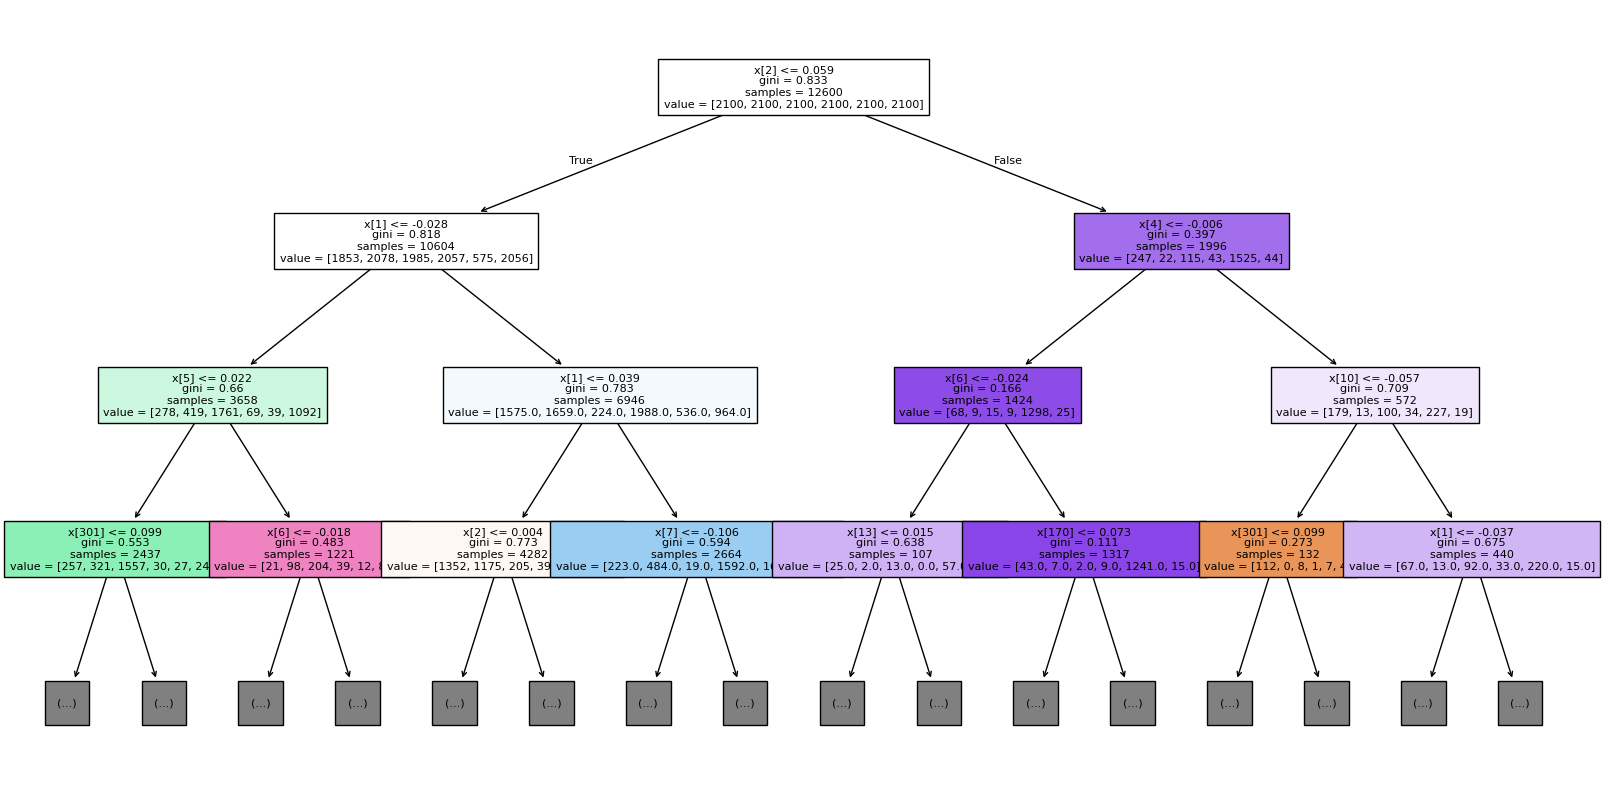

In [21]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20,10))
plot_tree(dt, filled=True, max_depth=3, fontsize=8)
plt.show()

In [22]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_test_bin = label_binarize(y_test_p, classes=labels)
n_classes = y_test_bin.shape[1]

models = {
    "LightGBM": best_lgbm_model,
    # "SVM (RBF)": best_svm_model,
    # "KNN": best_knn_model,
    # "Decision Tree": dt,
    # "Random Forest": rf,
    # "AdaBoost": ada
}

for name, model in models.items():
    plt.figure(figsize=(8, 6))

    # Decision function or predict_proba
    y_score = (
        model.decision_function(X_test_p)
        if hasattr(model, "decision_function")
        else model.predict_proba(X_test_p)
    )

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{labels[i]} (AUC={roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], "k--")
    plt.title(f"ROC Curves — {name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(fontsize=8)
    plt.grid(alpha=.3)
    plt.show()


NameError: name 'labels' is not defined

In [ ]:
errors = pd.DataFrame({"true": y_test_p, "pred": y_pred_lgbm_best})
mistakes = errors[errors["true"] != errors["pred"]]

top_confusions = (
    mistakes.groupby(["true", "pred"]).size()
    .sort_values(ascending=False)
    .head(10)
)

print("\nTOP MISCLASSIFICATIONS (Best LightGBM):\n")
print(top_confusions)


TOP MISCLASSIFICATIONS (Best LightGBM):

true                                                                  pred                                                                
international conference on acoustics, speech, and signal processing  international conference on image processing                            153
                                                                      international conference on communications                               97
international symposium on circuits and systems                       international conference on image processing                             82
international conference on acoustics, speech, and signal processing  international symposium on circuits and systems                          67
international symposium on circuits and systems                       international conference on acoustics, speech, and signal processing     54
Lecture Notes in Computer Science                                     international confe